# Quantum Kernel Machine Learning

## Overview

The general task of machine learning is to find and study patterns in data. For many datasets, the datapoints are better understood in a higher dimensional feature space. This is the fundamental principle behind a series of machine learning algorithms known as *kernel methods*.

In this notebook, you will learn how to define quantum kernels using `qiskit-machine-learning` and how these can be plugged into different algorithms to solve classification and clustering problems.

The content is structured as follows:

1. [Introduction](#intro)
2. [Classification](#class)    
3. [Clustering](#clustering)
4. [Conclusion](#conclusion)

All examples used in this tutorial are based on this reference paper: [_Supervised learning with quantum enhanced feature spaces_](https://arxiv.org/pdf/1804.11326.pdf).

<a id='intro'></a> 
## 1. Introduction

### 1.1. Kernel Methods for Machine Learning

Kernel methods are a collection of pattern analysis algorithms that use kernel functions to operate in a high-dimensional feature space. The best-known application of kernel methods is in **Support Vector Machines (SVMs)**, supervised learning algorithms commonly used for classification tasks. The main goal of SVMs is to find decision boundaries to separate a given set of data points into classes. When these data spaces are not linearly separable, SVMs can benefit from the use of kernels to find these boundaries.

Formally, decision boundaries are hyperplanes in a high dimensional space. The kernel function implicitly maps input data into this higher dimensional space, where it can be easier to solve the initial problem. In other words, kernels may allow data distributions that were originally non-linearly separable to become a linearly separable problem. This is an effect known as the "kernel trick".

There are use-cases for kernel-based unsupervised algorithms too, for example, in the context of clustering. **Spectral Clustering** is a technique where data points are treated as nodes of a graph, and the clustering task is viewed as a graph partitioning problem where nodes are mapped to a space where they can be easily segregated to form clusters.

### 1.2. Kernel Functions

Mathematically, kernel functions follow:

$k(\vec{x}_i, \vec{x}_j) = \langle f(\vec{x}_i), f(\vec{x}_j) \rangle$

where 
* $k$ is the kernel function
* $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs
* $f$ is a map from $n$-dimension to $m$-dimension space and 
* $\langle a,b \rangle$ denotes the inner product

When considering finite data, a kernel function can be represented as a matrix: 

$K_{ij} = k(\vec{x}_i,\vec{x}_j)$.

### 1.3. Quantum Kernels

The main idea behind quantum kernel machine learning is to leverage quantum feature maps to perform the kernel trick. In this case, the quantum kernel is created by mapping a classical feature vector $\vec{x}$ to a Hilbert space using a quantum feature map $\phi(\vec{x})$. Mathematically:

$K_{ij} = \left| \langle \phi(\vec{x}_i)| \phi(\vec{x}_j) \rangle \right|^{2}$

where 
* $K_{ij}$ is the kernel matrix
* $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs
* $\phi(\vec{x})$ is the quantum feature map
* $\left| \langle a|b \rangle \right|^{2}$ denotes the overlap of two quantum states $a$ and $b$

Quantum kernels can be plugged into common classical kernel learning algorithms such as SVMs or clustering algorithms, as you will see in the examples below. They can also be leveraged in new quantum kernel methods like `QSVC` [class](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.QSVC.html) provided by `qiskit-machine-learning` which is explored in this tutorial, and other methods as shown in later tutorials on [Pegasos QSVC](https://github.com/Qiskit/qiskit-machine-learning/blob/main/docs/tutorials/07_pegasos_qsvc.ipynb) and [QKA](https://github.com/Qiskit/qiskit-machine-learning/blob/main/docs/tutorials/08_quantum_kernel_trainer.ipynb).
***

Before introducing any example, we set up the global seed to ensure reproducibility:

In [1]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 12345

<a id='class'></a> 
## 2. Classification

This section illustrates a quantum kernel classification workflow using `qiskit-machine-learning`.

### 2.1. Defining the dataset

For this example, we will use the _ad hoc dataset_ as described in the reference [paper](https://arxiv.org/pdf/1804.11326.pdf). 

We can define the dataset dimension and get our train and test subsets:

In [1]:
from qiskit_machine_learning.datasets import ad_hoc_data

adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

In [2]:
train_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

This dataset is two-dimensional, the two features are represented by the $x$ and $y$ coordinates, and it has two class labels: A and B. We can plot it and see what the distribution looks like:

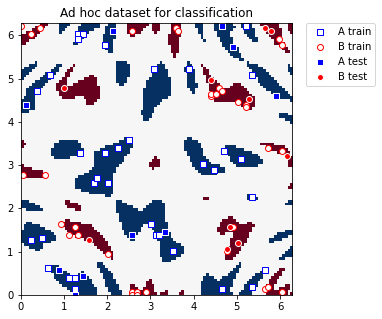

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

# A train plot
plt.scatter(
    train_features[
        np.where(train_labels[:] == 0), 0
    ],  # x coordinate of train_labels where class is 0
    train_features[
        np.where(train_labels[:] == 0), 1
    ],  # y coordinate of train_labels where class is 0
    marker="s",
    facecolors="w",
    edgecolors="b",
    label="A train",
)

# B train plot
plt.scatter(
    train_features[
        np.where(train_labels[:] == 1), 0
    ],  # x coordinate of train_labels where class is 1
    train_features[
        np.where(train_labels[:] == 1), 1
    ],  # y coordinate of train_labels where class is 1
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="B train",
)

# A test plot
plt.scatter(
    test_features[np.where(test_labels[:] == 0), 0],  # x coordinate of test_labels where class is 0
    test_features[np.where(test_labels[:] == 0), 1],  # y coordinate of test_labels where class is 0
    marker="s",
    facecolors="b",
    edgecolors="w",
    label="A test",
)

# B test plot
plt.scatter(
    test_features[np.where(test_labels[:] == 1), 0],  # x coordinate of test_labels where class is 1
    test_features[np.where(test_labels[:] == 1), 1],  # y coordinate of test_labels where class is 1
    marker="o",
    facecolors="r",
    edgecolors="w",
    label="B test",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset for classification")

plt.show()

### 2.2. Defining the quantum kernel

The next step is to create a quantum kernel instance that will help classify this data. 

We use the `FidelityQuantumKernel` [class](https://github.com/Qiskit/qiskit-machine-learning/blob/main/qiskit_machine_learning/kernels/fidelity_quantum_kernel.py), and pass two input arguments to its constructor: 

1. `feature_map`: in this case, a two-qubit `ZZFeatureMap` [instance](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html).

2. `fidelity`: in this case, the `ComputeUncompute` [fidelity](https://qiskit.org/documentation/stubs/qiskit.algorithms.state_fidelities.ComputeUncompute.html) subroutine that leverages the `Sampler` [primitive](https://qiskit.org/documentation/stubs/qiskit.primitives.Sampler.html).

**NOTE:** If you don't pass a `Sampler` or `Fidelity` instance, then the instances of the reference `Sampler` and `ComputeUncompute` classes (found in `qiskit.primitives`) will be created by default.

In [9]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

ImportError: cannot import name 'FidelityQuantumKernel' from 'qiskit_machine_learning.kernels' (/home/vasily/anaconda3/lib/python3.8/site-packages/qiskit_machine_learning/kernels/__init__.py)

### 2.3. Classification with SVC
The quantum kernel can now be plugged into classical kernel methods, such as the `SVC` [algorithm](https://scikit-learn.org/stable/modules/svm.html) from `scikit-learn`. This algorithm allows us to define a [custom kernel](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) in two ways: 
1. by providing the kernel as a **callable function**
2. by precomputing the **kernel matrix**

#### Kernel as a callable function

We define a SVC model and directly pass the `evaluate` function of the quantum kernel as a callable. Once the model is created, we train it by calling the `fit` method on the training dataset and evaluate the model for accuracy with `score`.

In [ ]:
from sklearn.svm import SVC

adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)

adhoc_svc.fit(train_features, train_labels)

adhoc_score_callable_function = adhoc_svc.score(test_features, test_labels)

print(f"Callable kernel classification test score: {adhoc_score_callable_function}")

#### Precomputed kernel matrix

Instead of passing a function of the quantum kernel as a callable, we can also precompute training and testing kernel matrices before passing them to the `scikit-learn` `SVC` algorithm. 

To extract the train and test matrices, we can call `evaluate` on the previously defined kernel and visualize them graphically as follows:

In [ ]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

To use these matrices, we set the `kernel` parameter of a new `SVC` instance to `"precomputed"`. We train the classifier by calling `fit` with the training matrix and training dataset. Once the model is trained, we evaluate it using the test matrix on the test dataset.

In [ ]:
adhoc_svc = SVC(kernel="precomputed")

adhoc_svc.fit(adhoc_matrix_train, train_labels)

adhoc_score_precomputed_kernel = adhoc_svc.score(adhoc_matrix_test, test_labels)

print(f"Precomputed kernel classification test score: {adhoc_score_precomputed_kernel}")

### 2.4. Classification with QSVC

`QSVC` is an alternative training algorithm provided by `qiskit-machine-learning` for convenience. It is an extension of `SVC` that takes in a quantum kernel instead of the `kernel.evaluate` method shown before.

In [ ]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=adhoc_kernel)

qsvc.fit(train_features, train_labels)

qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

### 2.5. Evaluation of models used for classification

In [ ]:
print(f"Classification Model                    | Accuracy Score")
print(f"---------------------------------------------------------")
print(f"SVC using kernel as a callable function | {adhoc_score_callable_function:10.2f}")
print(f"SVC using precomputed kernel matrix     | {adhoc_score_precomputed_kernel:10.2f}")
print(f"QSVC                                    | {qsvc_score:10.2f}")

As the classification dataset is small, we find that the three models achieve 100% accuracy.

<a id='clustering'></a> 
## 3. Clustering

The second workflow in this tutorial focuses on a clustering task using `qiskit-machine-learning` and the spectral clustering algorithm from `scikit-learn`.

### 3.1. Defining the dataset

We will once again use the _ad hoc dataset_, but now generated with a higher gap of `0.6` (previous example: `0.3`) between the two classes. 

Note that clustering falls under the category of unsupervised machine learning, so a test dataset is not required.

In [ ]:
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=25,
    test_size=0,
    n=adhoc_dimension,
    gap=0.6,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

 We plot the clustering dataset below:

In [ ]:
plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

# A label plot
plt.scatter(
    # x coordinate (index 0) of training data where class is A or label is 0
    train_features[np.where(train_labels[:] == 0), 0],
    # y coordinate (index 1) of training data where class is A or label is 0
    train_features[np.where(train_labels[:] == 0), 1],
    marker="s",
    facecolors="w",
    edgecolors="b",
    label="A",
)

# B label plot
plt.scatter(
    # x coordinate (index 0) of training data where class is B or label is 1
    train_features[np.where(train_labels[:] == 1), 0],
    # y coordinate (index 1) of training data where class is B or label is 1
    train_features[np.where(train_labels[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="B",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset for clustering")

plt.show()

### 3.2. Defining the Quantum Kernel
We use an identical setup as in the classification example. We create another instance of the `FidelityQuantumKernel` class with a `ZZFeatureMap`, but you might notice that in this case we do not provide a `fidelity` instance. This is because the `ComputeUncompute` method provided in the previous case is instantiated by default when the fidelity instance is not provided explicitly. 

In [ ]:
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

adhoc_kernel = FidelityQuantumKernel(feature_map=adhoc_feature_map)

### 3.3. Clustering with the Spectral Clustering Model

The `scikit-learn` spectral clustering algorithm allows us to define a custom kernel in two ways (just like `SVC`):
1. by providing the kernel as a **callable function**
2. by precomputing the **kernel matrix**. 

With the current `FidelityQuantumKernel` class in `qiskit-machine-learning`, we can only use the latter option, so we precompute the kernel matrix by calling `evaluate` and visualize it as follows:

In [ ]:
adhoc_matrix = adhoc_kernel.evaluate(x_vec=train_features)

plt.figure(figsize=(5, 5))
plt.imshow(np.asmatrix(adhoc_matrix), interpolation="nearest", origin="upper", cmap="Greens")
plt.title("Ad hoc clustering kernel matrix")
plt.show()

Next, we define a spectral clustering model and fit it using the precomputed kernel. Further, we score the labels using normalized mutual information, since we know the class labels a priori (before hand).

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

adhoc_spectral = SpectralClustering(2, affinity="precomputed")

cluster_labels = adhoc_spectral.fit_predict(adhoc_matrix)

cluster_score = normalized_mutual_info_score(cluster_labels, train_labels)

print(f"Clustering score: {cluster_score}")

In [ ]:
print("hello!")

## 4. Kernel Principal Component Analysis

This section focuses on Principal Component Analysis task using `KernelPLCA` algorithm. We calculate the kernel matrix using `ZZFeatureMap` and show that this approach allows to construct new coordinates, i.e. _principal components_, in which the classification task can be performed with simple `LogisticRegression` model from `scikit-learn`.

### 4.1. Defining the dataset

We again use the _ad hoc dataset_ a gap of `0.6` between the two classes. The plot will be exactly the same as it was in the previous case.

In [7]:
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=35,
    test_size=10,
    n=adhoc_dimension,
    gap=0.6,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

We plot training and test datasets below. Our ultimate goal in this section is to construct new coordinates where two classes can be lineary separated.

In [3]:
_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(15, 6))


X_train =  train_features
X_test = test_features
y_train = train_labels
y_test = test_labels

train_ax.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

test_ax.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
    marker="o",
    facecolors="w",
    edgecolors="b",
    label="A")
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test,
    marker="o",
    facecolors="w",
    edgecolors="b",
    label="B")

test_ax.set_ylabel("Feature #1")    
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

plt.show()

NameError: name 'plt' is not defined

### 4.2 Defining the Quantum Kernel

We proceed with a similar kernel as it was in the classification task, namely `ZZFeatureMap` circuit in the instance of `FidelityQuantumKernel`.

In [4]:
feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement="linear")
q_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

NameError: name 'ZZFeatureMap' is not defined

In [ ]:
matrix_train = q_kernel.evaluate(x_vec= X_train)
matrix_test = q_kernel.evaluate(x_vec= X_test, y_vec= X_test)

### 4.3 KPCA comparison between quantum and gaussian kernels

In this section we use `KernelPCA` instances with the `kernel` parameter set to gaussian kernel `"rbf"` and `"precomputed"`. The former is very popular in classical machine learning models, whereas the latter allows using a quantum `q_kernel` which was defined above. We then train two models with the `fit` method, as was done in classification tasks. One can observe that in Kernel PCA the model based on the gaussian kernel fails to separate `ad_hoc_data` points, while the quantum kernel successfully transfers the initial dataset into a linearly separable one.

It is also should be mentioned, that in this case each point from the input dataset is represented in the quantum circuit as a vector with 4 coordinates, after using Kernel PCA only 2 coordinates are left.

In [5]:
from sklearn.decomposition import KernelPCA

kernel_pca_rbf = KernelPCA(n_components=2, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1)
X_train_kernel_rbf = kernel_pca_rbf.fit(X_train).transform(X_train)

X_train_kernel_pca = kernel_pca.fit_transform(matrix_train)
X_test_kernel_pca = kernel_pca.fit_transform(matrix_test)

NameError: name 'X_train' is not defined

In [6]:
fig, (kernel_pca_proj_ax,kernel_pca_rbf_proj_ax) = plt.subplots(
    ncols=2, figsize=(10, 5)
)

kernel_pca_proj_ax.scatter(X_train_kernel_rbf[:, 0], X_train_kernel_rbf[:, 1], c=y_train)
kernel_pca_proj_ax.set_ylabel("Principal component #1")
kernel_pca_proj_ax.set_xlabel("Principal component #0")
_ = kernel_pca_proj_ax.set_title("Projection of training data\n using KernelPCA")

kernel_pca_rbf_proj_ax.scatter(X_train_kernel_pca[:, 0],X_train_kernel_pca[:, 1], c=y_train)

kernel_pca_rbf_proj_ax.scatter(X_test_kernel_pca[:, 0],X_test_kernel_pca[:, 1], c=y_test,cmap='Paired')
kernel_pca_rbf_proj_ax.set_ylabel("Principal component #1")
kernel_pca_rbf_proj_ax.set_xlabel("Principal component #0")
_ = kernel_pca_rbf_proj_ax.set_title("Projection of training and testing data\n using PCA with Quantum Kernel")

NameError: name 'plt' is not defined

### 4.4 Logistic Regression in new coordinates.

It is possible now to apply  the separation with `scikit-learn`,
`LogisticRegression` model and show that the linear clasification can be performed within new coordinates `Principal component #0` and `Principal component #1` with a high accuracy. We use `score` method to get the accuracy of our model.

In [ ]:
from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()

In [ ]:
logisticRegr.fit(X_train_kernel_pca, y_train)

In [ ]:
predictions = logisticRegr.predict(X_test_kernel_pca)
score = logisticRegr.score(X_test_kernel_pca, y_test)
print(score)

In [ ]:
h = .001  # step size in the mesh

# create a mesh to plot in
x_min, x_max = X_train_kernel_pca[:, 0].min() - 1, X_train_kernel_pca[:, 0].max() + 1
y_min, y_max = X_train_kernel_pca[:, 1].min() - 1, X_train_kernel_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

from matplotlib.pyplot import figure
figure(figsize=(5, 5), dpi=80)

Z = logisticRegr.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.2)

    # Plot also the training points
plt.scatter(X_train_kernel_pca[:, 0], X_train_kernel_pca[:, 1], c=y_train)
plt.scatter(X_test_kernel_pca[:, 0], X_test_kernel_pca[:, 1], c=y_test,cmap='Paired')
plt.xlabel("Principal component #0")
plt.ylabel("Principal component #1")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title("Final Separation")

plt.show()

<a id='conclusion'></a> 
## 5. Conclusion

In this tutorial:

* We reviewed the fundamentals of quantum kernel learning
* We understood how to define quantum kernels as instances of `FidelityQuantumKernel`
* We learned how to use the `scikit-learn` `SVC` algorithm with a custom quantum kernel as a callable function vs precomputed quantum kernel matrix for classification
* We learned how to train classifiers with the `QSVC` algorithm from `qiskit-machine-learning`
* We learned how to use the `scikit-learn` `SpectralClustering` algorithms with a precomputed quantum kernel matrix for clustering
* We investigated how to implemet quantum kernel into `scikit-learn` `KernelPCA` algorithm and obtained new coordinates in which ad-hoc dataset can be classified by using `LogisticRegression`.

For further reference, `scikit-learn` has other algorithms that can use a precomputed kernel matrix, such as:

- [Agglomerative clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)
- [Support vector regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)
- [Ridge regression](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)
- [Gaussian process regression](https://scikit-learn.org/stable/modules/gaussian_process.html)
- [Principal component analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html)

In [ ]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright